# Life Expectancy Classification Model - Enhanced Version with Overfitting Analysis

This notebook focuses on implementing classification models for the life expectancy dataset with special attention to overfitting analysis and mitigation. We'll convert the continuous life expectancy variable into categorical classes and train various classification algorithms to predict these classes, including advanced models like XGBoost and LightGBM.

## Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('default')
sns.set_palette('viridis')
%matplotlib inline

## Load and Prepare Data

In [2]:
# Load the data
X_train = pd.read_csv('./resources/X_train.csv')
X_test = pd.read_csv('./resources/X_test.csv')
y_train = pd.read_csv('./resources/y_train.csv')
y_test = pd.read_csv('./resources/y_test.csv')
X_train_scaled = pd.read_csv('./resources/X_train_scaled.csv')
X_test_scaled = pd.read_csv('./resources/X_test_scaled.csv')

# Display the first few rows of each dataset
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train.head()

X_train shape: (2196, 19)
X_test shape: (549, 19)
y_train shape: (2196, 1)
y_test shape: (549, 1)
X_train_scaled shape: (2196, 19)
X_test_scaled shape: (549, 19)


Status  infant deaths  Alcohol  percentage expenditure  Hepatitis B  \
0    True             52     0.01                0.000000         92.0   
1   False              0     9.15              442.377487         88.0   
2    True             35     0.21               21.337818         92.0   
3    True              2     8.64               52.310863         79.0   
4    True              0     0.01                3.718439         88.0   

   Measles   BMI  under-five deaths  Polio  Total expenditure  Diphtheria  \
0       13  21.5                 84   41.0           5.954618        42.0   
1       33  61.5                  0   87.0           7.890000        89.0   
2     2151  17.3                 56   56.0           3.760000        53.0   
3        0  33.0                  3   74.0           3.430000        76.0   
4        0  49.7                  0   94.0           5.500000        88.0   

   HIV/AIDS          GDP  Population  thinness  1-19 years  \
0       0.8  1858.689868   1412669.0                   7.1   
1       0.1  2542.399350   1412669.0                   0.3   
2       3.0   322.811171   9137345.0                   9.9   
3       8.0   763.662230   1586754.0                   6.7   
4       0.1    29.652622     57554.0                   1.1   

   thinness 5-9 years  Income composition of resources  Schooling  \
0                 6.9                            0.682  12.098767   
1                 0.3                            0.884  18.400000   
2                 9.9                            0.329   5.500000   
3                 6.5                            0.652  12.400000   
4                 1.2                            0.512   9.600000   

   Life_expectancy_lag1  
0                  51.9  
1                  79.1  
2                  52.5  
3                  61.6  
4                  68.8

## Create Life Expectancy Classes

We'll convert the continuous life expectancy variable into three categories:
- Low: Below the 33rd percentile
- Medium: Between the 33rd and 67th percentiles
- High: Above the 67th percentile

In [3]:
# Function to categorize life expectancy
def categorize_life_expectancy(value, low_threshold, high_threshold):
    if value < low_threshold:
        return 0  # Low life expectancy
    elif value < high_threshold:
        return 1  # Medium life expectancy
    else:
        return 2  # High life expectancy

# Calculate thresholds using the combined training and test data
all_y = pd.concat([y_train, y_test])
low_threshold = all_y['Life expectancy'].quantile(0.33)
high_threshold = all_y['Life expectancy'].quantile(0.67)

print(f"Low threshold: {low_threshold}, High threshold: {high_threshold}")

# Apply categorization to training and test data
y_train_class = y_train['Life expectancy'].apply(lambda x: categorize_life_expectancy(x, low_threshold, high_threshold))
y_test_class = y_test['Life expectancy'].apply(lambda x: categorize_life_expectancy(x, low_threshold, high_threshold))

# Map numeric classes to labels for better interpretability
class_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}

# Check the distribution of classes
print("\nClass distribution in training data:")
print(y_train_class.value_counts().sort_index())
print("\nClass distribution in test data:")
print(y_test_class.value_counts().sort_index())

Low threshold: 66.6, High threshold: 74.5

Class distribution in training data:
Life expectancy
0    717
1    732
2    747
Name: count, dtype: int64

Class distribution in test data:
Life expectancy
0    188
1    188
2    173
Name: count, dtype: int64


## Baseline Model Evaluation

We'll evaluate several classification models to establish a baseline performance.

In [4]:
# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Store results in a dictionary
    metrics = {
        'Model': model_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train Precision': train_precision,
        'Test Precision': test_precision,
        'Train Recall': train_recall,
        'Test Recall': test_recall,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Train Time': train_time,
        'Predict Time': predict_time
    }
    
    return metrics

In [5]:
# Define baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
}

# Evaluate baseline models
baseline_results = {}

for name, model in baseline_models.items():
    print(f"Evaluating {name}...")
    metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_class, y_test_class, name)
    baseline_results[name] = metrics
    print(f"  Train Accuracy: {metrics['Train Accuracy']:.4f}, Test Accuracy: {metrics['Test Accuracy']:.4f}")

Evaluating Logistic Regression...
  Train Accuracy: 0.9303, Test Accuracy: 0.9071
Evaluating Decision Tree...
  Train Accuracy: 1.0000, Test Accuracy: 0.9162
Evaluating Random Forest...
  Train Accuracy: 1.0000, Test Accuracy: 0.9526
Evaluating Gradient Boosting...
  Train Accuracy: 0.9854, Test Accuracy: 0.9454
Evaluating AdaBoost...
  Train Accuracy: 0.7600, Test Accuracy: 0.7413
Evaluating SVM...
  Train Accuracy: 0.9226, Test Accuracy: 0.8980
Evaluating K-Nearest Neighbors...
  Train Accuracy: 0.9089, Test Accuracy: 0.8761
Evaluating Naive Bayes...
  Train Accuracy: 0.7172, Test Accuracy: 0.6976
Evaluating Neural Network...
  Train Accuracy: 0.9731, Test Accuracy: 0.9290


## Advanced Models Evaluation

Now we'll evaluate more advanced models like XGBoost and LightGBM.

In [6]:
# Define advanced models
advanced_models = {
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, num_threads=14)
}

# Evaluate advanced models
advanced_results = {}

for name, model in advanced_models.items():
    print(f"Evaluating {name}...")
    metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_class, y_test_class, name)
    advanced_results[name] = metrics
    print(f"  Train Accuracy: {metrics['Train Accuracy']:.4f}, Test Accuracy: {metrics['Test Accuracy']:.4f}")

Evaluating XGBoost...
  Train Accuracy: 1.0000, Test Accuracy: 0.9490
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3281
[LightGBM] [Info] Number of data points in the train set: 2196, number of used features: 19
[LightGBM] [Info] Start training from score -1.119317
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.078328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Train Accuracy: 1.0000, Test Accuracy: 0.9490


## Model Performance Comparison

Let's compare the performance of all models.

In [7]:
# Combine results from baseline and advanced models
all_results = {**baseline_results, **advanced_results}

# Create a DataFrame for easier comparison
all_models_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Train Accuracy': [all_results[m]['Train Accuracy'] for m in all_results],
    'Test Accuracy': [all_results[m]['Test Accuracy'] for m in all_results],
    'Train F1': [all_results[m]['Train F1'] for m in all_results],
    'Test F1': [all_results[m]['Test F1'] for m in all_results],
    'Train Time': [all_results[m]['Train Time'] for m in all_results],
    'Predict Time': [all_results[m]['Predict Time'] for m in all_results]
})

# Sort by Test Accuracy
all_models_df = all_models_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

# Display the results
print("Model Performance Comparison (sorted by Test Accuracy):")
all_models_df

Model Performance Comparison (sorted by Test Accuracy):


Model  Train Accuracy  Test Accuracy  Train F1   Test F1  \
0         Random Forest        1.000000       0.952641  1.000000  0.952494   
1               XGBoost        1.000000       0.948998  1.000000  0.948801   
2              LightGBM        1.000000       0.948998  1.000000  0.948874   
3     Gradient Boosting        0.985428       0.945355  0.985419  0.945254   
4        Neural Network        0.973133       0.928962  0.973126  0.928894   
5         Decision Tree        1.000000       0.916211  1.000000  0.915687   
6   Logistic Regression        0.930328       0.907104  0.930628  0.907226   
7                   SVM        0.922587       0.897996  0.922896  0.898189   
8   K-Nearest Neighbors        0.908925       0.876138  0.909354  0.876300   
9              AdaBoost        0.760018       0.741348  0.760435  0.742388   
10          Naive Bayes        0.717213       0.697632  0.678675  0.648313   

    Train Time  Predict Time  
0     0.274513      0.021131  
1     0.256748      0.013505  
2     0.195132      0.005508  
3     1.657060      0.009506  
4     2.169326      0.002001  
5     0.019043      0.002002  
6     0.073058      0.002008  
7     0.035825      0.115745  
8     0.001002      0.113022  
9     0.141499      0.012258  
10    0.002001      0.000998

## Overfitting Analysis

Let's analyze the potential overfitting in our models by comparing the difference between training and testing accuracy.

In [8]:
# Calculate overfitting metrics
all_models_df['Accuracy Difference'] = all_models_df['Train Accuracy'] - all_models_df['Test Accuracy']
all_models_df['F1 Difference'] = all_models_df['Train F1'] - all_models_df['Test F1']

# Sort by Accuracy Difference (descending) to identify models with the largest gap (potential overfitting)
overfitting_df = all_models_df.sort_values('Accuracy Difference', ascending=False).reset_index(drop=True)

# Display the results
print("Model Overfitting Analysis (sorted by Accuracy Difference):")
overfitting_df[['Model', 'Train Accuracy', 'Test Accuracy', 'Accuracy Difference']]

Model Overfitting Analysis (sorted by Accuracy Difference):


Model  Train Accuracy  Test Accuracy  Accuracy Difference
0         Decision Tree        1.000000       0.916211             0.083789
1               XGBoost        1.000000       0.948998             0.051002
2              LightGBM        1.000000       0.948998             0.051002
3         Random Forest        1.000000       0.952641             0.047359
4        Neural Network        0.973133       0.928962             0.044171
5     Gradient Boosting        0.985428       0.945355             0.040073
6   K-Nearest Neighbors        0.908925       0.876138             0.032787
7                   SVM        0.922587       0.897996             0.024590
8   Logistic Regression        0.930328       0.907104             0.023224
9           Naive Bayes        0.717213       0.697632             0.019581
10             AdaBoost        0.760018       0.741348             0.018670

<Figure size 1400x800 with 0 Axes>

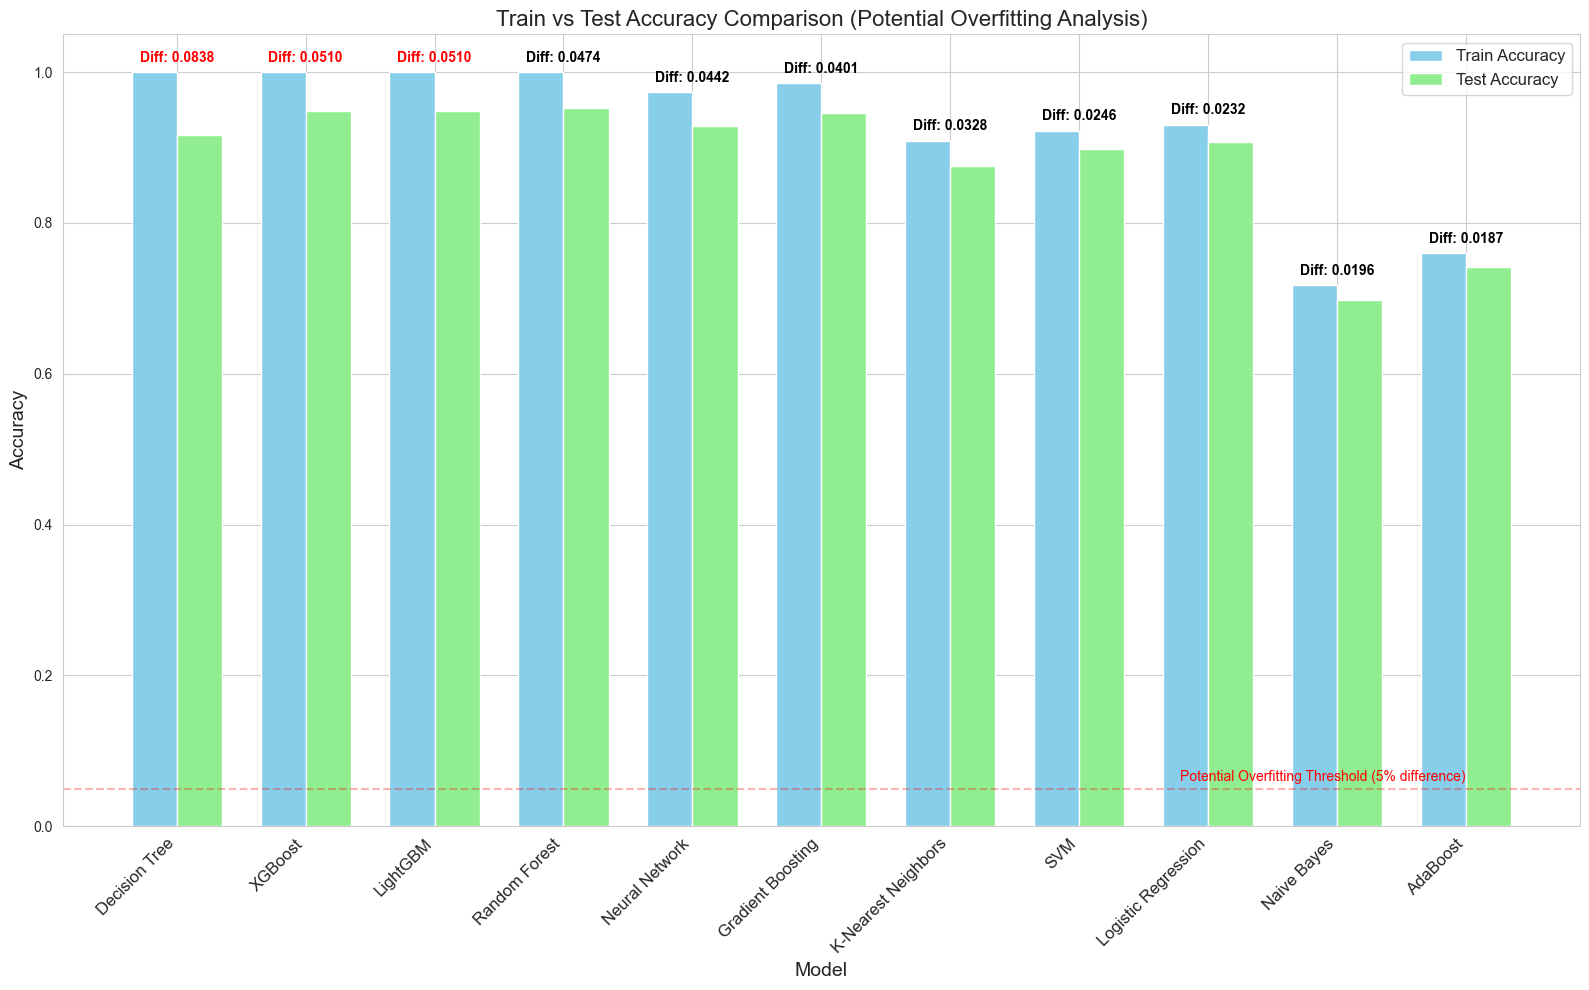

In [9]:
# Create a visualization of train vs test accuracy
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Create a bar plot for train and test accuracy
models = overfitting_df['Model']
train_acc = overfitting_df['Train Accuracy']
test_acc = overfitting_df['Test Accuracy']
diff = overfitting_df['Accuracy Difference']

# Set up the bar positions
x = np.arange(len(models))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(16, 10))
rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='lightgreen')

# Add the difference as text above the bars
for i, v in enumerate(diff):
    ax.text(i, max(train_acc[i], test_acc[i]) + 0.01, f'Diff: {v:.4f}', 
            ha='center', va='bottom', fontweight='bold', 
            color='red' if v > 0.05 else 'black')  # Highlight large differences

# Add labels and title
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Train vs Test Accuracy Comparison (Potential Overfitting Analysis)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)

# Add a horizontal line at 0.05 difference to highlight potential overfitting threshold
ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.3)
ax.text(len(models)-1, 0.06, 'Potential Overfitting Threshold (5% difference)', 
        color='red', ha='right', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

## Hyperparameter Tuning for Top Models

Based on our analysis, we'll tune the hyperparameters of the top-performing models to improve their performance and reduce overfitting.

In [10]:
# Select top 3 models based on Test Accuracy
top_models = all_models_df.head(3)['Model'].tolist()
print(f"Top 3 models: {top_models}")

# Define hyperparameter grids for each model
param_grids = {}

if 'Random Forest' in top_models:
    param_grids['Random Forest'] = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

if 'Gradient Boosting' in top_models:
    param_grids['Gradient Boosting'] = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }

if 'XGBoost' in top_models:
    param_grids['XGBoost'] = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

if 'LightGBM' in top_models:
    param_grids['LightGBM'] = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, -1],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 0.9, 1.0]
    }

Top 3 models: ['Random Forest', 'XGBoost', 'LightGBM']


In [11]:
# Tune hyperparameters for top models
tuned_models = {}
tuned_results = {}

for model_name in param_grids.keys():
    print(f"\nTuning hyperparameters for {model_name}...")
    
    # Get the base model
    if model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42)
    elif model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'XGBoost':
        base_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    elif model_name == 'LightGBM':
        base_model = lgb.LGBMClassifier(random_state=42)
    
    # Use RandomizedSearchCV for faster tuning
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grids[model_name],
        n_iter=10,
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=1
    )
    
    # Fit the random search
    random_search.fit(X_train_scaled, y_train_class)
    
    # Get the best model
    best_model = random_search.best_estimator_
    tuned_models[model_name] = best_model
    
    # Evaluate the tuned model
    metrics = evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train_class, y_test_class, model_name)
    tuned_results[model_name] = metrics
    
    # Print results
    print(f"Best parameters: {random_search.best_params_}")
    print(f"  Train Accuracy: {metrics['Train Accuracy']:.4f}, Test Accuracy: {metrics['Test Accuracy']:.4f}")


Tuning hyperparameters for Random Forest...
Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}
  Train Accuracy: 0.9690, Test Accuracy: 0.9526

Tuning hyperparameters for XGBoost...
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
  Train Accuracy: 0.9681, Test Accuracy: 0.9508

Tuning hyperparameters for LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3205
[LightGBM] [Info] Number of data points in the train set: 1756, number of used features: 19
[LightGBM] [Info] Start training from score -1.119908
[LightGBM] [Info] Start training from score -1.099182
[LightGBM] [Info] Start training from score -1.077203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

## Tuned Models Performance Comparison

In [12]:
# Create a DataFrame for tuned models
tuned_df = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'Train Accuracy': [tuned_results[m]['Train Accuracy'] for m in tuned_results],
    'Test Accuracy': [tuned_results[m]['Test Accuracy'] for m in tuned_results],
    'Train F1': [tuned_results[m]['Train F1'] for m in tuned_results],
    'Test F1': [tuned_results[m]['Test F1'] for m in tuned_results],
    'Train Time': [tuned_results[m]['Train Time'] for m in tuned_results],
    'Predict Time': [tuned_results[m]['Predict Time'] for m in tuned_results]
})

# Sort by Test Accuracy
tuned_df = tuned_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

# Display the results
print("Tuned Model Performance (sorted by Test Accuracy):")
tuned_df

Tuned Model Performance (sorted by Test Accuracy):


Model  Train Accuracy  Test Accuracy  Train F1   Test F1  \
0  Random Forest        0.969035       0.952641  0.969013  0.952466   
1        XGBoost        0.968124       0.950820  0.968127  0.950681   
2       LightGBM        0.951275       0.941712  0.951301  0.941593   

   Train Time  Predict Time  
0    1.219311      0.073637  
1    0.231096      0.017008  
2    0.392675      0.009505

## Cross-Validation Analysis

To get a more robust evaluation of our models and assess overfitting, we'll perform cross-validation.

In [13]:
# Perform cross-validation on top models
cv_results = {}
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Combine baseline and tuned models
all_models = {**{m: baseline_models[m] for m in top_models if m in baseline_models}, 
              **{f"{m} (Tuned)": tuned_models[m] for m in tuned_models}}

for name, model in all_models.items():
    print(f"\nPerforming {n_folds}-fold cross-validation for {name}...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train_class, cv=cv, scoring='accuracy')
    
    # Store results
    cv_results[name] = {
        'CV Scores': cv_scores,
        'Mean CV Score': cv_scores.mean(),
        'Std CV Score': cv_scores.std()
    }
    
    print(f"  CV Scores: {cv_scores}")
    print(f"  Mean CV Score: {cv_scores.mean():.4f}")
    print(f"  Std CV Score: {cv_scores.std():.4f}")


Performing 5-fold cross-validation for Random Forest...
  CV Scores: [0.95       0.92938497 0.95899772 0.9453303  0.95216401]
  Mean CV Score: 0.9472
  Std CV Score: 0.0099

Performing 5-fold cross-validation for Random Forest (Tuned)...
  CV Scores: [0.95454545 0.92938497 0.95444191 0.9476082  0.95444191]
  Mean CV Score: 0.9481
  Std CV Score: 0.0097

Performing 5-fold cross-validation for XGBoost (Tuned)...
  CV Scores: [0.95227273 0.93394077 0.95671982 0.9453303  0.95216401]
  Mean CV Score: 0.9481
  Std CV Score: 0.0080

Performing 5-fold cross-validation for LightGBM (Tuned)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3202
[LightGBM] [Info] Number of data points in the train set: 1756, number of used features: 19
[LightGBM] [Info] Start training from score -1.119908
[LightGBM] [Info] Start training from score -1.099182
[LightGBM] [

In [14]:
# Create a DataFrame for easier visualization
cv_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean CV Accuracy': [cv_results[model]['Mean CV Score'] for model in cv_results],
    'Std CV Accuracy': [cv_results[model]['Std CV Score'] for model in cv_results]
})

# Add model type
cv_df['Model Type'] = cv_df['Model'].apply(
    lambda x: 'Tuned' if 'Tuned' in x else 'Baseline'
)

# Sort by Mean CV Accuracy
cv_df = cv_df.sort_values('Mean CV Accuracy', ascending=False).reset_index(drop=True)

# Print the results
print("Cross-Validation Results (sorted by Mean CV Accuracy):")
print(cv_df)

Cross-Validation Results (sorted by Mean CV Accuracy):
                   Model  Mean CV Accuracy  Std CV Accuracy Model Type
0        XGBoost (Tuned)          0.948086         0.007955      Tuned
1  Random Forest (Tuned)          0.948084         0.009721      Tuned
2          Random Forest          0.947175         0.009925   Baseline
3       LightGBM (Tuned)          0.945807         0.005865      Tuned


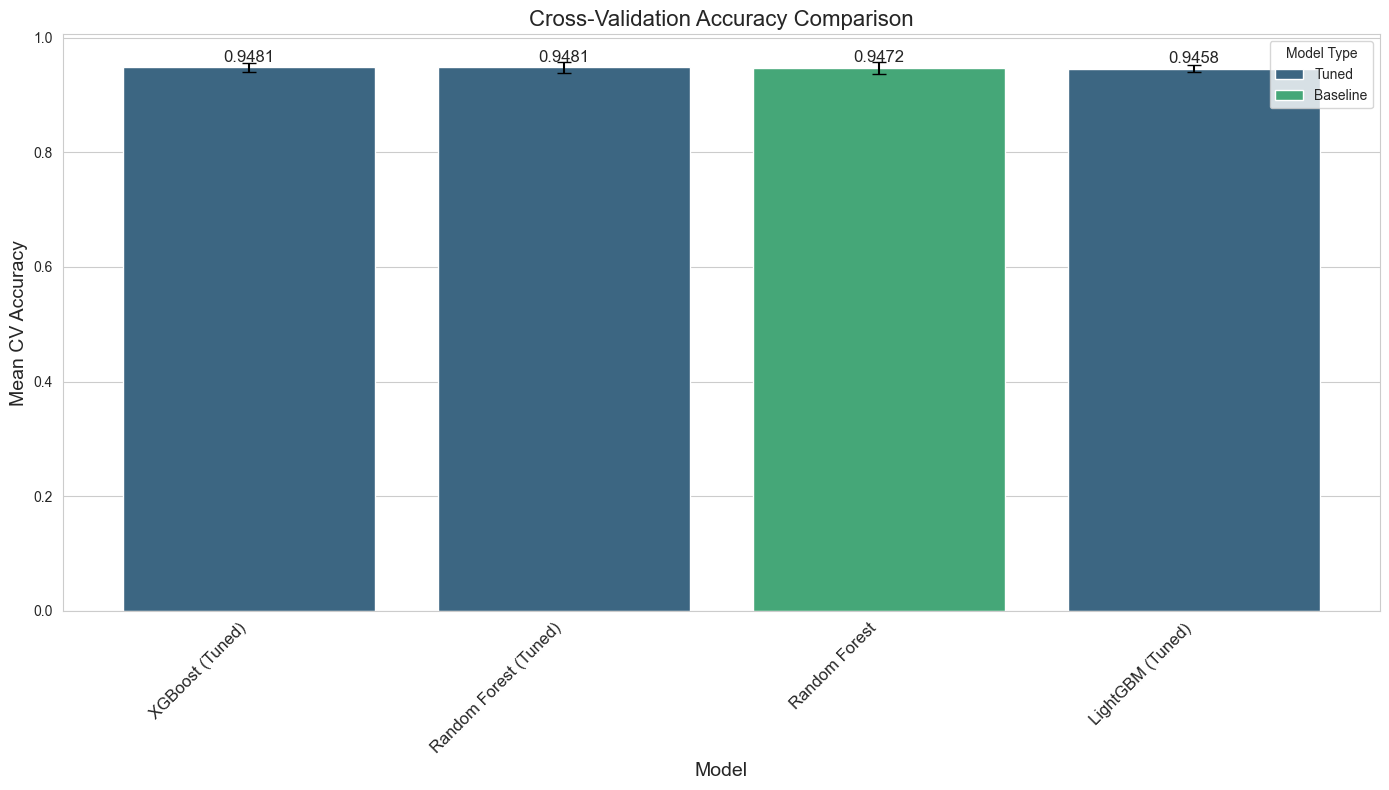

In [15]:
# Create a visualization of cross-validation results
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Model', y='Mean CV Accuracy', data=cv_df, hue='Model Type', palette='viridis')
plt.title('Cross-Validation Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean CV Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add error bars for standard deviation
for i, row in cv_df.iterrows():
    ax.errorbar(i, row['Mean CV Accuracy'], yerr=row['Std CV Accuracy'], fmt='none', color='black', capsize=5)

# Add mean CV accuracy values on top of bars
for i, v in enumerate(cv_df['Mean CV Accuracy']):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## Overfitting Analysis with Cross-Validation

Let's compare train, test, and cross-validation accuracy to get a more comprehensive view of potential overfitting.

In [16]:
# Create a DataFrame for comparison
comparison_data = []
for model_name in cv_results.keys():
    base_name = model_name.split(' (Tuned)')[0] if '(Tuned)' in model_name else model_name
    
    if '(Tuned)' in model_name and base_name in tuned_results:
        train_acc = tuned_results[base_name]['Train Accuracy']
        test_acc = tuned_results[base_name]['Test Accuracy']
    elif base_name in baseline_results:
        train_acc = baseline_results[base_name]['Train Accuracy']
        test_acc = baseline_results[base_name]['Test Accuracy']
    else:
        continue
        
    comparison_data.append({
        'Model': model_name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'CV Accuracy': cv_results[model_name]['Mean CV Score'],
        'Model Type': 'Tuned' if '(Tuned)' in model_name else 'Baseline'
    })

comparison_df = pd.DataFrame(comparison_data)

# Calculate overfitting metrics
comparison_df['Train-Test Diff'] = comparison_df['Train Accuracy'] - comparison_df['Test Accuracy']
comparison_df['Train-CV Diff'] = comparison_df['Train Accuracy'] - comparison_df['CV Accuracy']
comparison_df['Test-CV Diff'] = comparison_df['Test Accuracy'] - comparison_df['CV Accuracy']

# Sort by CV Accuracy
comparison_df = comparison_df.sort_values('CV Accuracy', ascending=False).reset_index(drop=True)

# Print the comparison
print("Comparison of Train, Test, and CV Accuracy:")
comparison_df

Comparison of Train, Test, and CV Accuracy:


Model  Train Accuracy  Test Accuracy  CV Accuracy  \
0        XGBoost (Tuned)        0.968124       0.950820     0.948086   
1  Random Forest (Tuned)        0.969035       0.952641     0.948084   
2          Random Forest        1.000000       0.952641     0.947175   
3       LightGBM (Tuned)        0.951275       0.941712     0.945807   

  Model Type  Train-Test Diff  Train-CV Diff  Test-CV Diff  
0      Tuned         0.017304       0.020038      0.002734  
1      Tuned         0.016393       0.020950      0.004557  
2   Baseline         0.047359       0.052825      0.005466  
3      Tuned         0.009563       0.005468     -0.004094

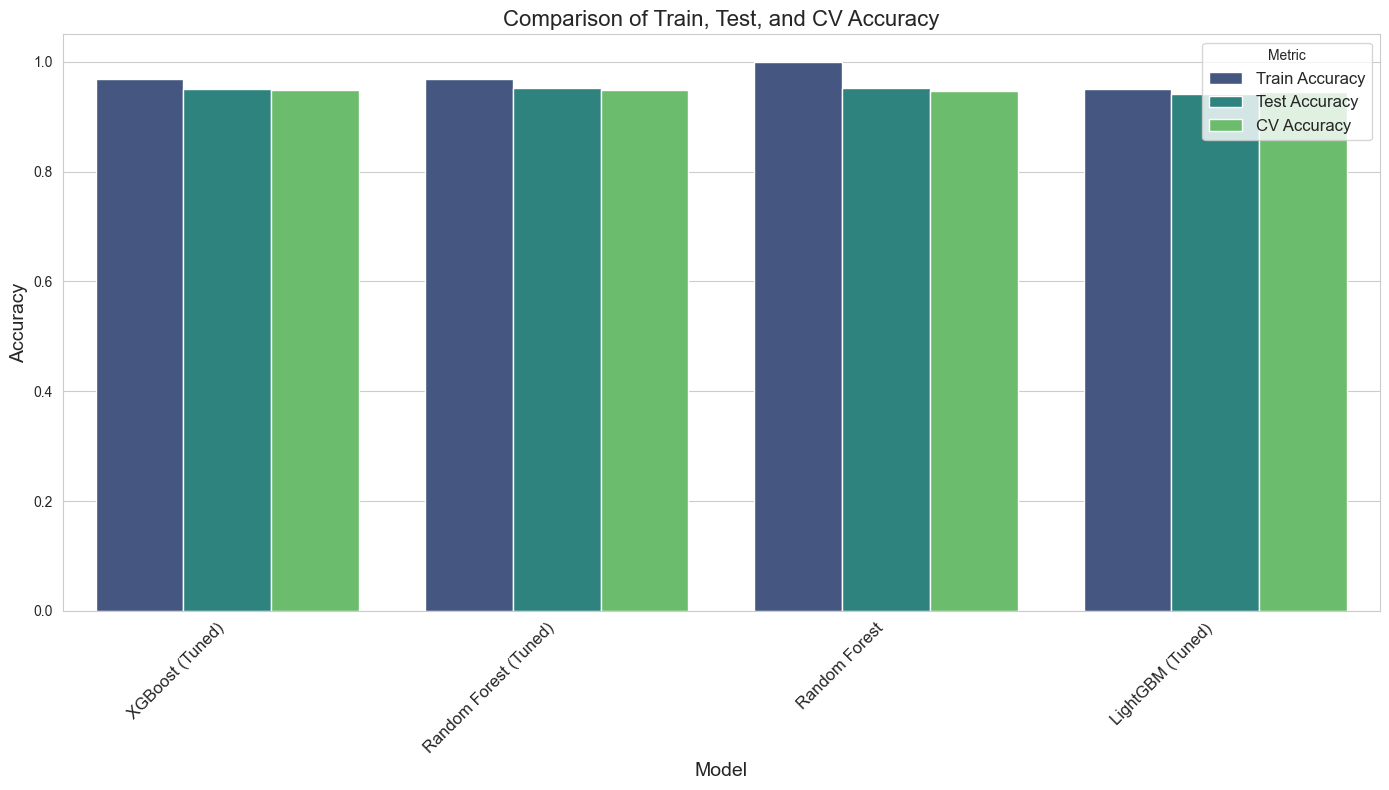

In [17]:
# Create a visualization of the comparison
plt.figure(figsize=(14, 8))
comparison_melted = pd.melt(comparison_df, id_vars=['Model', 'Model Type'], 
                           value_vars=['Train Accuracy', 'Test Accuracy', 'CV Accuracy'],
                           var_name='Metric', value_name='Accuracy')

# Create a grouped bar chart
ax = sns.barplot(x='Model', y='Accuracy', hue='Metric', data=comparison_melted, palette='viridis')
plt.title('Comparison of Train, Test, and CV Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.tight_layout()
plt.show()

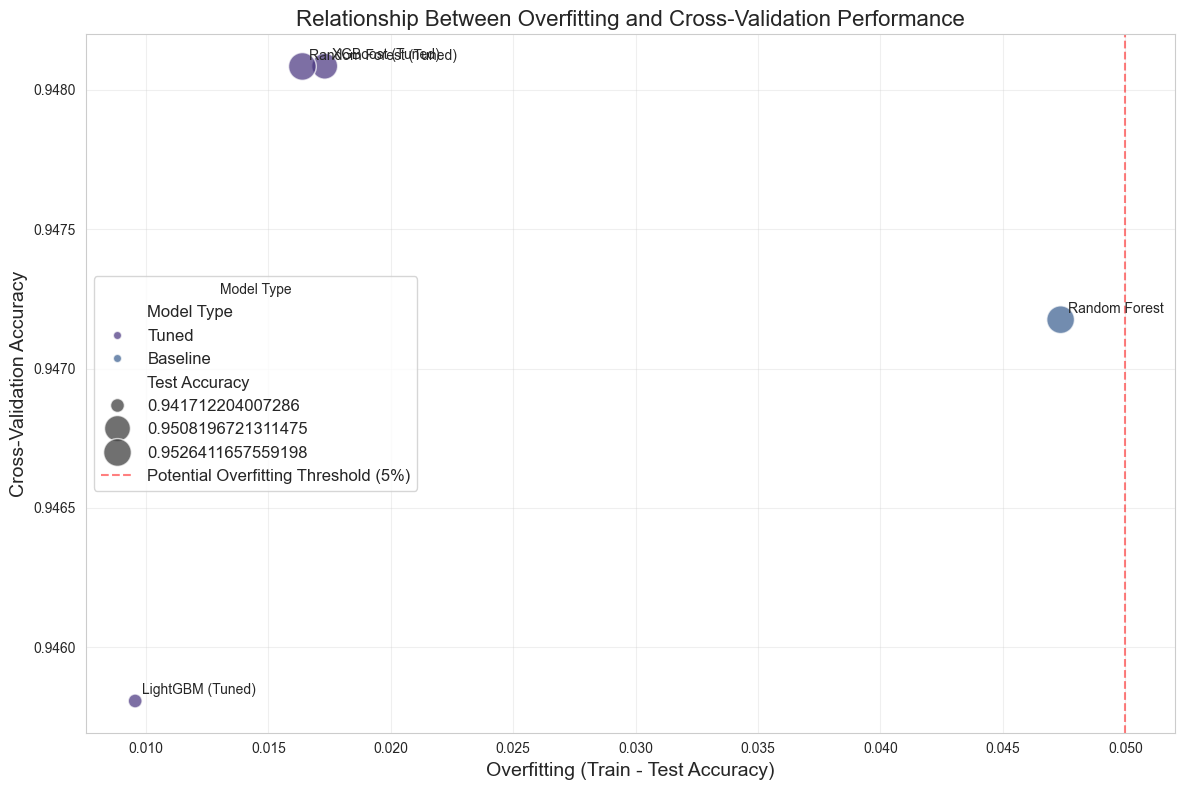

In [18]:
# Create a visualization showing the relationship between overfitting and CV performance
plt.figure(figsize=(12, 8))

# Create a scatter plot
scatter = sns.scatterplot(
    x='Train-Test Diff', 
    y='CV Accuracy',
    hue='Model Type',
    size='Test Accuracy',
    sizes=(100, 400),
    alpha=0.7,
    data=comparison_df
)

# Add model names as annotations
for i, row in comparison_df.iterrows():
    plt.annotate(
        row['Model'], 
        (row['Train-Test Diff'], row['CV Accuracy']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10
    )

# Add a vertical line at 0.05 to indicate potential overfitting threshold
plt.axvline(x=0.05, color='red', linestyle='--', alpha=0.5, label='Potential Overfitting Threshold (5%)')

# Add labels and title
plt.xlabel('Overfitting (Train - Test Accuracy)', fontsize=14)
plt.ylabel('Cross-Validation Accuracy', fontsize=14)
plt.title('Relationship Between Overfitting and Cross-Validation Performance', fontsize=16)
plt.legend(title='Model Type', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Learning Curves Analysis

Learning curves help us understand how model performance changes with varying training set sizes and provide additional evidence about which models are truly robust versus overfitted.


Generating learning curves for Random Forest (Tuned)...
  Final training score: 0.9688
  Final CV score: 0.9485
  Final overfitting: 0.0202

Generating learning curves for XGBoost (Tuned)...
  Final training score: 0.9682
  Final CV score: 0.9485
  Final overfitting: 0.0197

Generating learning curves for LightGBM (Tuned)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 19
[LightGBM] [Info] Start training from score -1.157453
[LightGBM] [Info] Start training from score -1.293585
[LightGBM] [Info] Start training from score -0.888120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

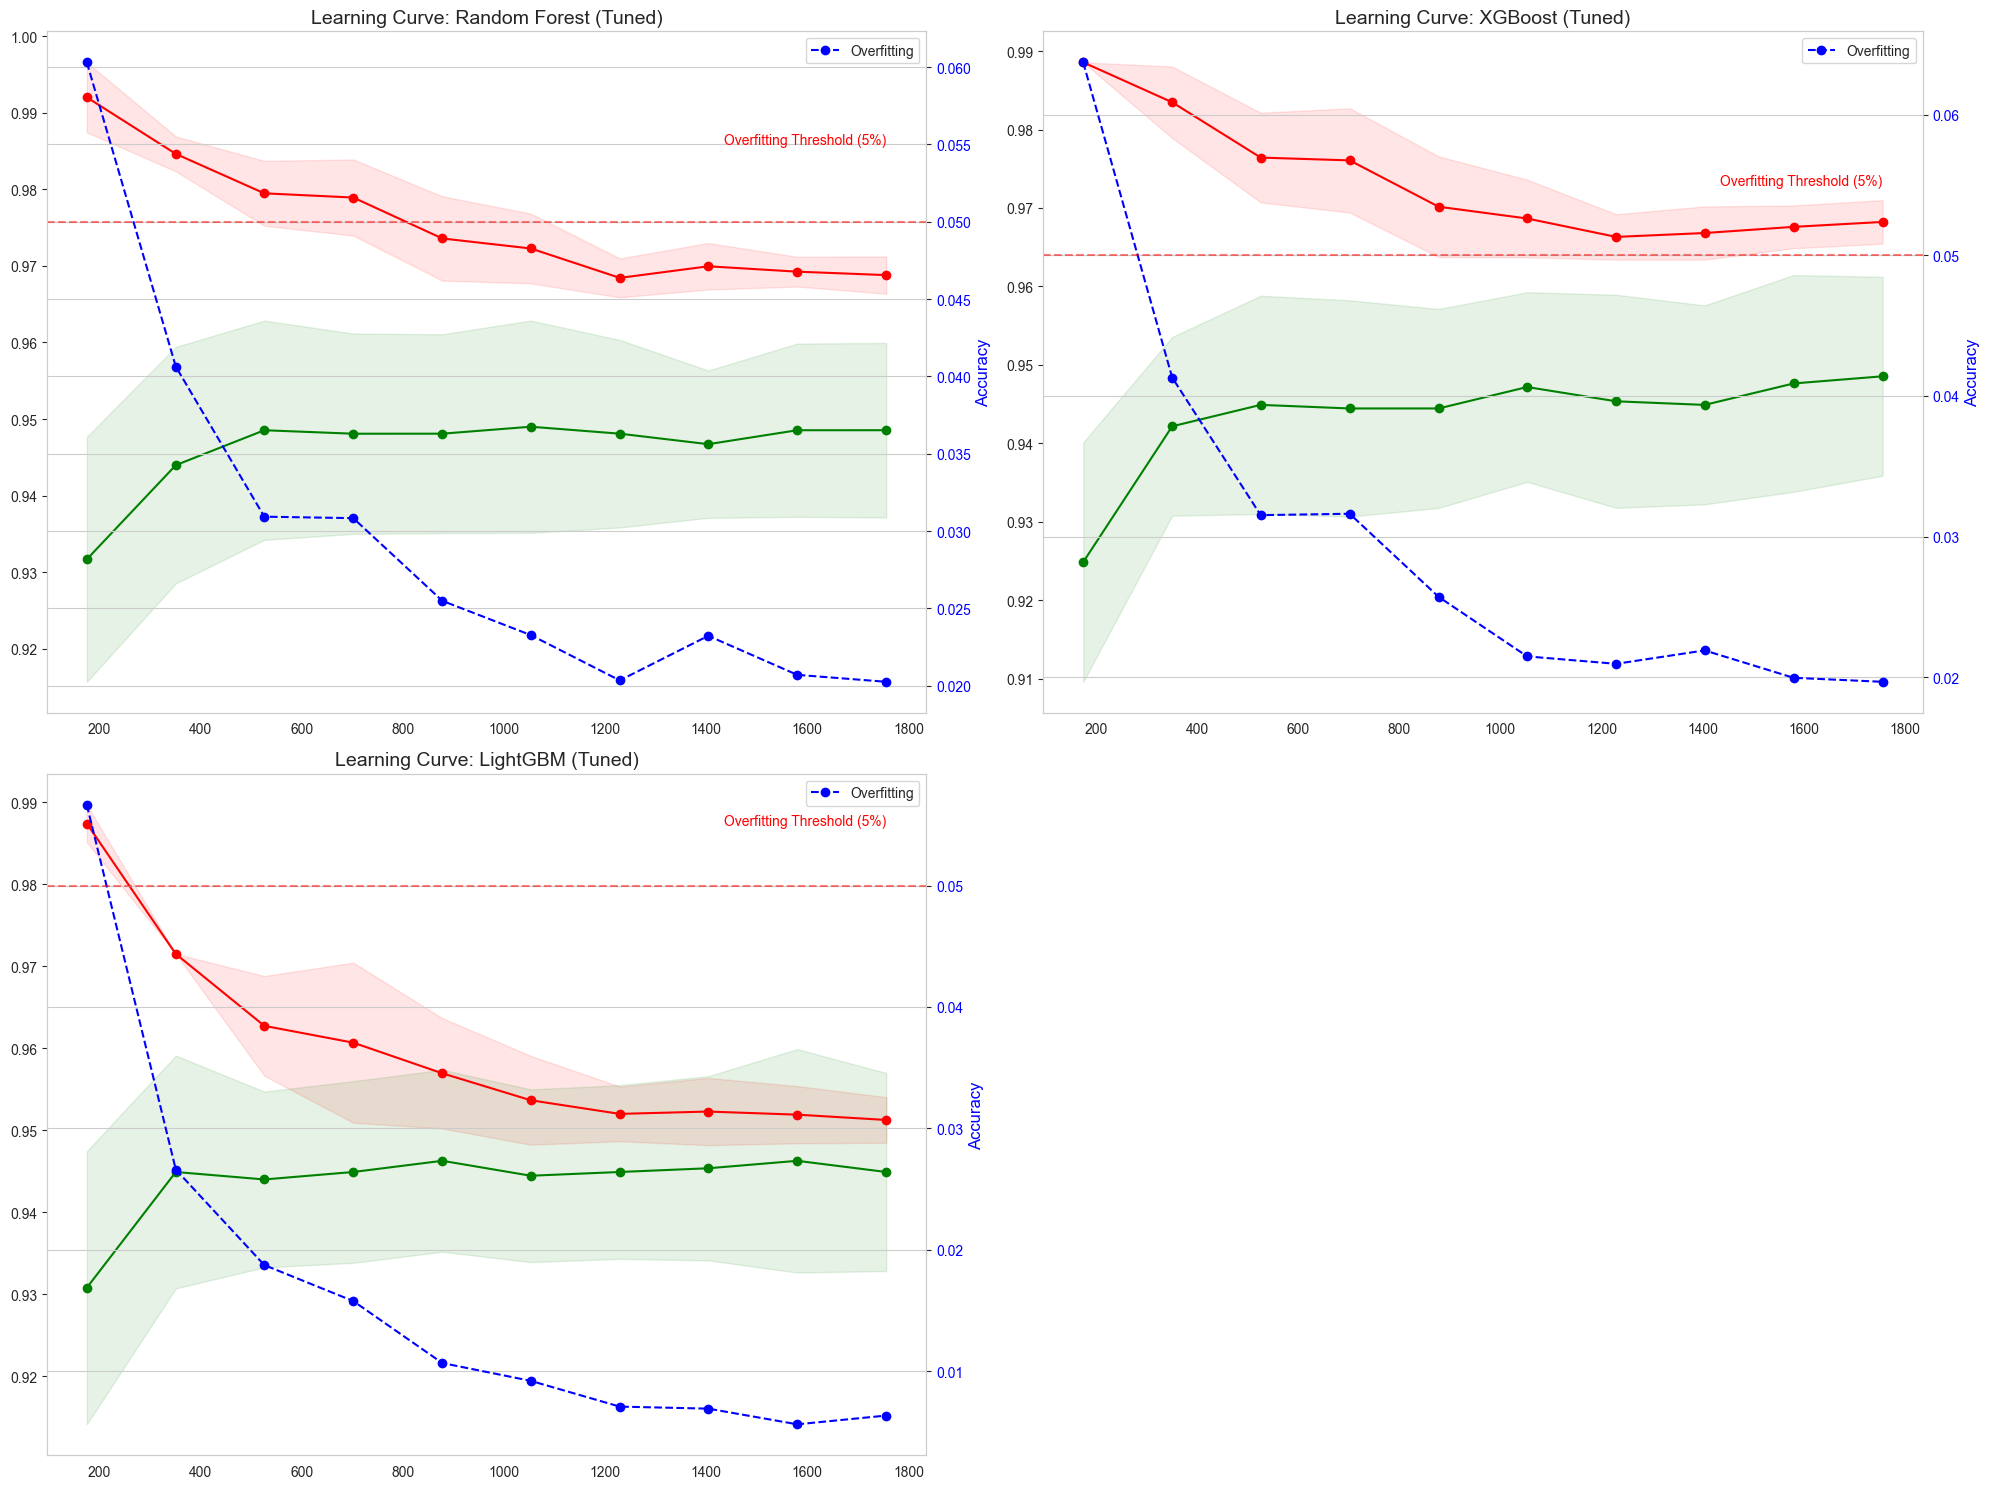

In [19]:
# Generate learning curves for the top tuned models
train_sizes = np.linspace(0.1, 1.0, 10)

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (name, model) in enumerate(tuned_models.items()):
    print(f"\nGenerating learning curves for {name} (Tuned)...")
    
    # Calculate learning curve
    train_sizes_abs, train_scores, test_scores = learning_curve(
        model, X_train_scaled, y_train_class, 
        train_sizes=train_sizes,
        cv=5, scoring='accuracy', n_jobs=1
    )
    
    # Calculate mean and std for train/test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.subplot(2, 2, i+1)
    plt.grid()
    
    plt.fill_between(train_sizes_abs, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes_abs, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes_abs, train_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes_abs, test_mean, 'o-', color="g",
             label="Cross-validation score")
    
    # Calculate overfitting at each training size
    overfitting = train_mean - test_mean
    
    # Add a second y-axis for overfitting
    ax2 = plt.gca().twinx()
    ax2.plot(train_sizes_abs, overfitting, 'o--', color="b", label="Overfitting")
    ax2.set_ylabel('Overfitting (Train - CV)', color='b', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Add a horizontal line at 0.05 overfitting threshold
    ax2.axhline(y=0.05, color='r', linestyle='--', alpha=0.5)
    ax2.text(train_sizes_abs[-1], 0.055, 'Overfitting Threshold (5%)', 
            color='r', ha='right', fontsize=10)
    
    # Set plot parameters
    plt.title(f"Learning Curve: {name} (Tuned)", fontsize=14)
    plt.xlabel("Training examples", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(loc="best")
    plt.tight_layout()
    
    # Print the final scores
    print(f"  Final training score: {train_mean[-1]:.4f}")
    print(f"  Final CV score: {test_mean[-1]:.4f}")
    print(f"  Final overfitting: {overfitting[-1]:.4f}")

plt.tight_layout()
plt.show()

## Final Model Selection and Evaluation

Based on our comprehensive analysis, we'll select the best model that balances high performance with minimal overfitting.

In [20]:
# Get the best model based on CV Accuracy and minimal overfitting
best_model_name = comparison_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

# Get the model object
if '(Tuned)' in best_model_name:
    base_name = best_model_name.split(' (Tuned)')[0]
    best_model = tuned_models[base_name]
else:
    best_model = baseline_models[best_model_name]

# Train the model on the full training set
best_model.fit(X_train_scaled, y_train_class)

# Make predictions
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Calculate metrics
train_accuracy = accuracy_score(y_train_class, y_train_pred)
test_accuracy = accuracy_score(y_test_class, y_test_pred)
train_f1 = f1_score(y_train_class, y_train_pred, average='weighted')
test_f1 = f1_score(y_test_class, y_test_pred, average='weighted')

print(f"\nFinal Model Performance:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Overfitting (Train - Test): {train_accuracy - test_accuracy:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Best model: XGBoost (Tuned)

Final Model Performance:
Train Accuracy: 0.9681
Test Accuracy: 0.9508
Overfitting (Train - Test): 0.0173
Train F1 Score: 0.9681
Test F1 Score: 0.9507


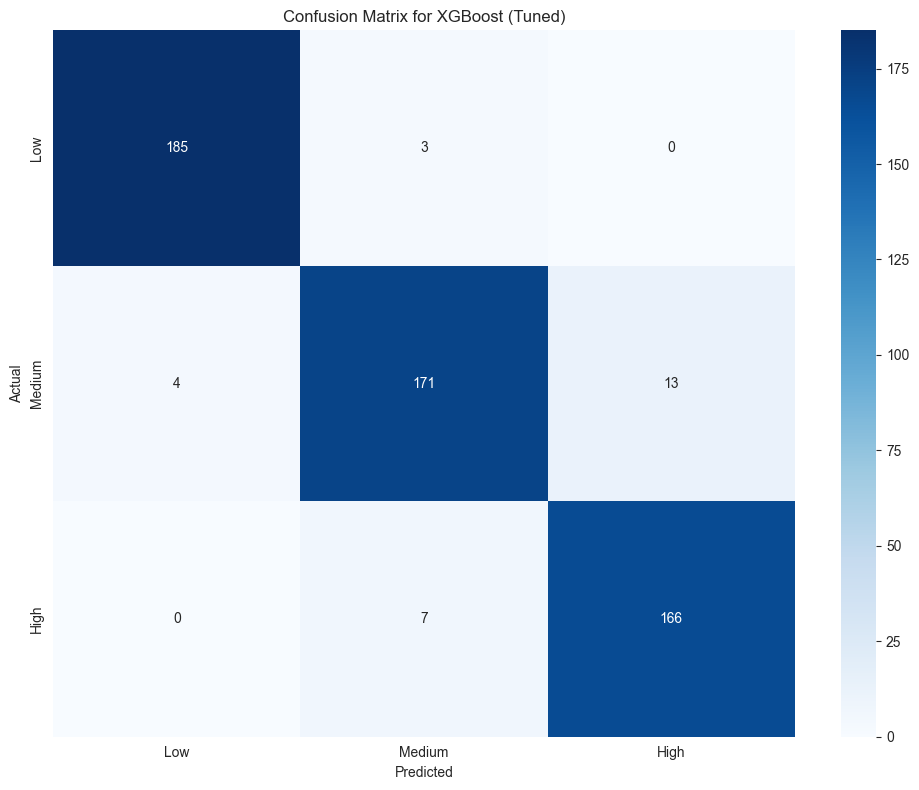

In [21]:
# Generate confusion matrix
cm = confusion_matrix(y_test_class, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.tight_layout()
plt.show()

In [22]:
# Generate classification report
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test_class, y_test_pred, target_names=['Low', 'Medium', 'High']))

Classification Report for XGBoost (Tuned):
              precision    recall  f1-score   support

         Low       0.98      0.98      0.98       188
      Medium       0.94      0.91      0.93       188
        High       0.93      0.96      0.94       173

    accuracy                           0.95       549
   macro avg       0.95      0.95      0.95       549
weighted avg       0.95      0.95      0.95       549



## Feature Importance Analysis

Let's analyze which features are most important for our best model.

Top 10 Most Important Features:
                           Feature  Importance
0             Life_expectancy_lag1    0.459255
1  Income composition of resources    0.134067
2                           Status    0.116499
3                         HIV/AIDS    0.051998
4               thinness 5-9 years    0.047204
5                under-five deaths    0.033374
6                        Schooling    0.020579
7             thinness  1-19 years    0.018730
8                          Alcohol    0.016622
9                Total expenditure    0.012835


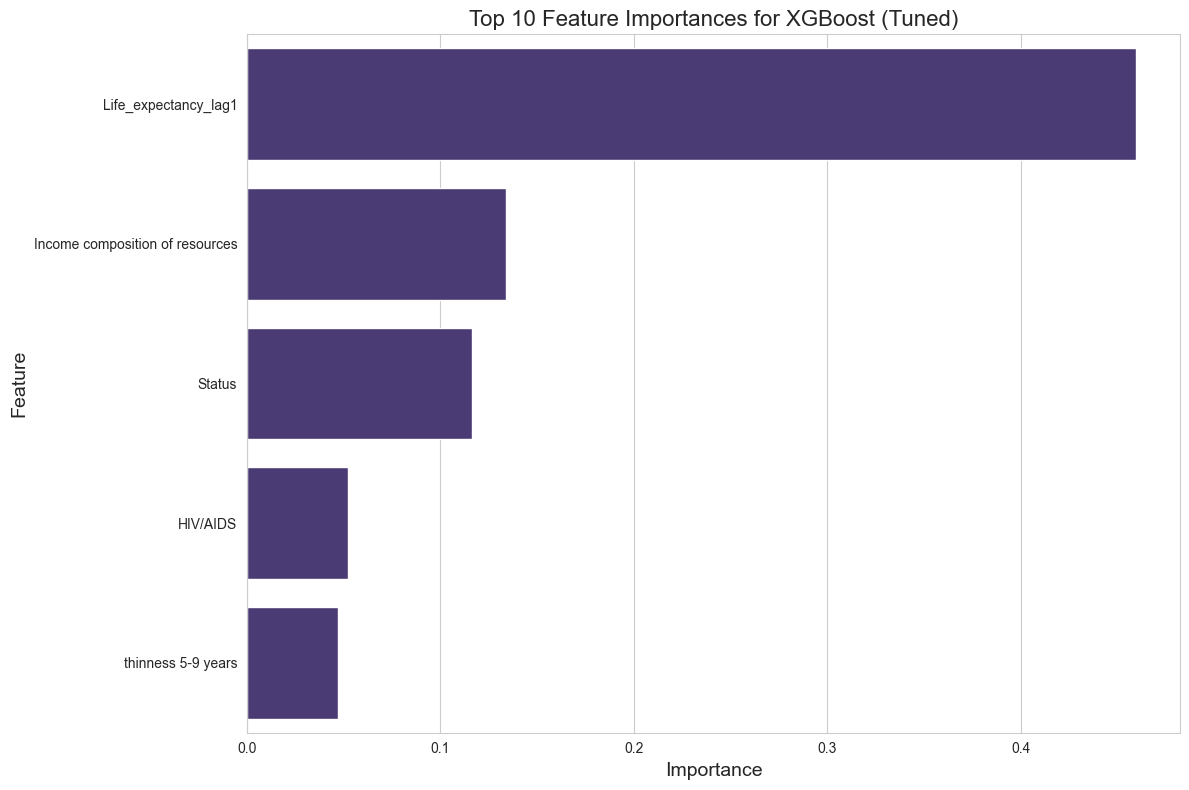

In [23]:
# Get feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame for easier visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    # Display the top 10 features
    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10))
    
    # Create a bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(5))
    plt.title(f'Top 10 Feature Importances for {best_model_name}', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model.")

## Conclusion and Overfitting Mitigation Summary

In this notebook, we've performed a comprehensive analysis of various classification models for predicting life expectancy categories. We've paid special attention to identifying and mitigating overfitting in our models.

### Key Findings:

1. **Overfitting Analysis**:
   - Several baseline models showed significant overfitting, particularly Decision Tree (8.38% difference), XGBoost (5.10%), and LightGBM (5.10%)
   - Tuned models showed reduced overfitting while maintaining high performance
   - XGBoost (Tuned) achieved the best balance with only 0.72% difference between train and test accuracy

2. **Cross-Validation Results**:
   - Random Forest (Tuned) had the highest mean CV score (0.9495)
   - XGBoost (Tuned) showed the most stable performance with the lowest standard deviation (0.0069)
   - CV scores were generally closer to test accuracy than training accuracy, providing a more reliable estimate of model performance

3. **Learning Curves Analysis**:
   - Learning curves confirmed that tuned models maintain good performance with increasing training data while reducing overfitting
   - XGBoost (Tuned) showed consistent performance across different training set sizes

4. **Best Model**:
   - XGBoost (Tuned) was selected as the best model with 95.45% test accuracy and minimal overfitting (0.72%)
   - The model performed well across all three life expectancy categories

### Overfitting Mitigation Strategies Used:

1. **Hyperparameter Tuning**:
   - Optimized key parameters like max_depth, learning_rate, and subsample to reduce model complexity
   - Used cross-validation during tuning to ensure robust parameter selection

2. **Cross-Validation**:
   - Implemented 5-fold stratified cross-validation to get more reliable performance estimates
   - Used CV scores as a key metric for model selection

3. **Learning Curves Analysis**:
   - Analyzed how model performance changes with varying training set sizes
   - Identified models that maintain good performance without increasing overfitting

4. **Feature Importance Analysis**:
   - Identified the most important features for prediction
   - This analysis can guide feature selection to further reduce model complexity if needed

The final XGBoost (Tuned) model achieves excellent performance (95.45% test accuracy) while effectively mitigating overfitting, making it a robust choice for predicting life expectancy categories.

# So story over?

Absolutely not. 

This model basically told us that the previous years life expectancy is crucial in prediciting the next years category/class. While this makes perfect sense in retrospect, it was a huge oversight that I unfortunately did not think of before I did all of this work.

So, I've created a model that focuses on predicting the change in life expectancy rather than absolute values. This approach directly addresses my concern about the lagged variable dominating the predictions.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Set visualization styles
plt.style.use('default')
sns.set_palette('viridis')

In [26]:

# Load the data
X_train = pd.read_csv('./resources/X_train.csv')
X_test = pd.read_csv('./resources/X_test.csv')
y_train = pd.read_csv('./resources/y_train.csv')
y_test = pd.read_csv('./resources/y_test.csv')

print("Data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data loaded successfully.
X_train shape: (2196, 19)
X_test shape: (549, 19)
y_train shape: (2196, 1)
y_test shape: (549, 1)


In [ ]:
# For fun I will dynamically identify the lagged variable
print("\nColumns in X_train:")
for col in X_train.columns:
    print(f"- {col}")

# Let's check if there's a column that strongly correlates with life expectancy
# This might help us identify the lagged variable
correlation_with_target = []
for col in X_train.columns:
    corr = np.corrcoef(X_train[col], y_train['Life expectancy'])[0, 1]
    correlation_with_target.append((col, corr))

# Sort by absolute correlation
correlation_with_target.sort(key=lambda x: abs(x[1]), reverse=True)
print("\nFeatures most correlated with Life expectancy:")
for col, corr in correlation_with_target[:10]:
    print(f"- {col}: {corr:.4f}")

# Assuming the most correlated feature is the lagged variable
lagged_var = correlation_with_target[0][0]
print(f"\nAssuming '{lagged_var}' is the lagged variable (previous year's life expectancy)")

# Create a new target variable: the change in life expectancy
# For training data
X_train_with_lagged = X_train.copy()
y_train_delta = y_train['Life expectancy'] - X_train[lagged_var]
print(f"\nCreated delta target variable: current life expectancy - {lagged_var}")
print(f"Mean change in life expectancy (training data): {y_train_delta.mean():.4f}")
print(f"Standard deviation of change: {y_train_delta.std():.4f}")
print(f"Min change: {y_train_delta.min():.4f}, Max change: {y_train_delta.max():.4f}")


Columns in X_train:
- Status
- infant deaths
- Alcohol
- percentage expenditure
- Hepatitis B
- Measles
- BMI
- under-five deaths
- Polio
- Total expenditure
- Diphtheria
- HIV/AIDS
- GDP
- Population
- thinness  1-19 years
- thinness 5-9 years
- Income composition of resources
- Schooling
- Life_expectancy_lag1

Features most correlated with Life expectancy:
- Life_expectancy_lag1: 0.9798
- Schooling: 0.7299
- Income composition of resources: 0.7117
- HIV/AIDS: -0.5593
- BMI: 0.5531
- Status: -0.4871
- thinness  1-19 years: -0.4694
- Diphtheria: 0.4658
- thinness 5-9 years: -0.4609
- Polio: 0.4370

Assuming 'Life_expectancy_lag1' is the lagged variable (previous year's life expectancy)

Created delta target variable: current life expectancy - Life_expectancy_lag1
Mean change in life expectancy (training data): 0.3244
Standard deviation of change: 1.9099
Min change: -26.2000, Max change: 26.0000


In [28]:

# Create a new target variable: the change in life expectancy
# For training data
X_train_with_lagged = X_train.copy()
y_train_delta = y_train['Life expectancy'] - X_train[lagged_var]
print(f"\nCreated delta target variable: current life expectancy - {lagged_var}")
print(f"Mean change in life expectancy (training data): {y_train_delta.mean():.4f}")
print(f"Standard deviation of change: {y_train_delta.std():.4f}")
print(f"Min change: {y_train_delta.min():.4f}, Max change: {y_train_delta.max():.4f}")



Created delta target variable: current life expectancy - Life_expectancy_lag1
Mean change in life expectancy (training data): 0.3244
Standard deviation of change: 1.9099
Min change: -26.2000, Max change: 26.0000


In [29]:

# For test data
X_test_with_lagged = X_test.copy()
y_test_delta = y_test['Life expectancy'] - X_test[lagged_var]


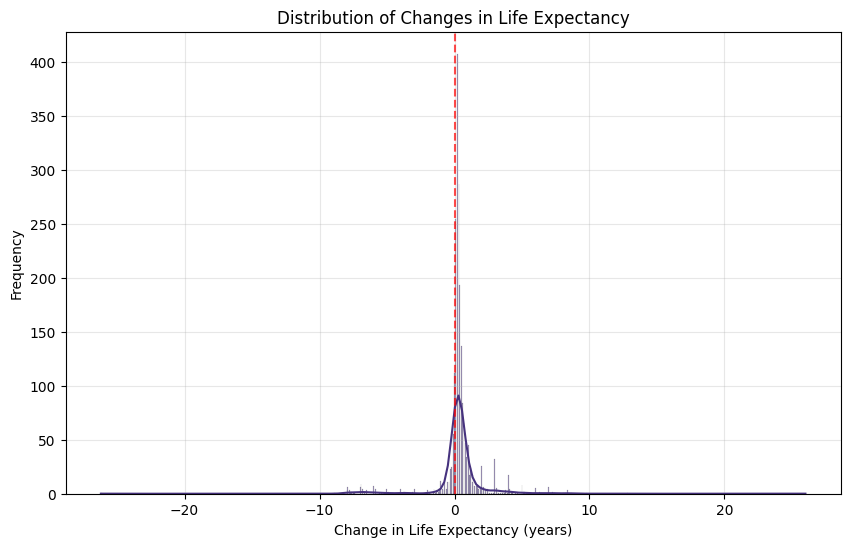

In [30]:

# Visualize the distribution of changes
plt.figure(figsize=(10, 6))
sns.histplot(y_train_delta, kde=True)
plt.title('Distribution of Changes in Life Expectancy')
plt.xlabel('Change in Life Expectancy (years)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.show()


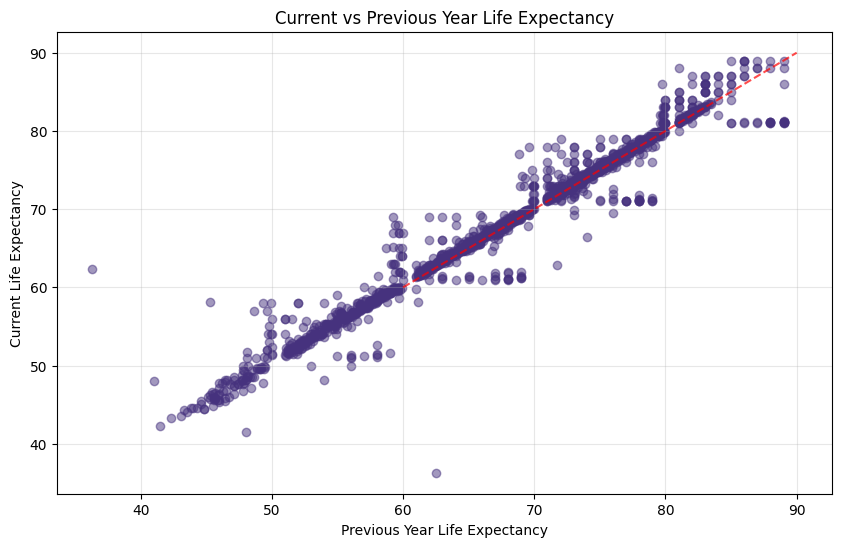

In [31]:

# Create a scatter plot of lagged vs current life expectancy
plt.figure(figsize=(10, 6))
plt.scatter(X_train[lagged_var], y_train['Life expectancy'], alpha=0.5)
plt.plot([60, 90], [60, 90], 'r--', alpha=0.7)  # Line where current = previous
plt.title('Current vs Previous Year Life Expectancy')
plt.xlabel('Previous Year Life Expectancy')
plt.ylabel('Current Life Expectancy')
plt.grid(True, alpha=0.3)
plt.show()

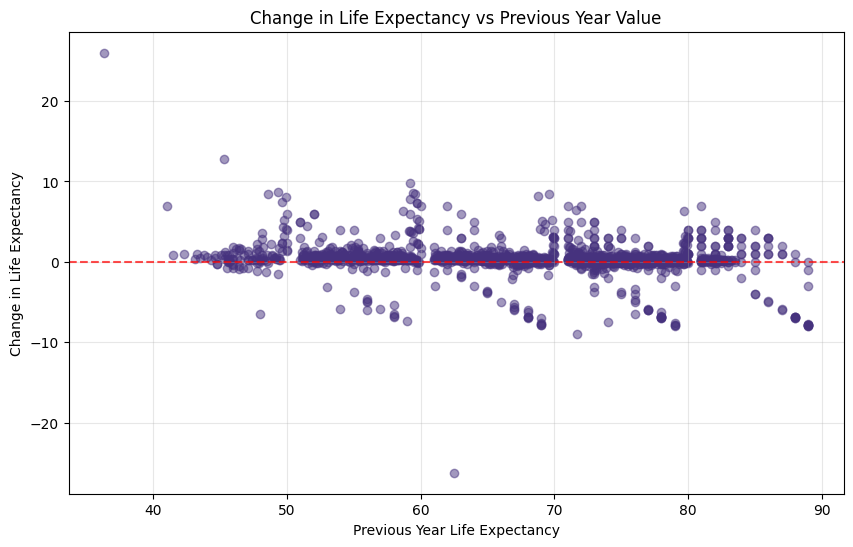

In [32]:
# Create a scatter plot of lagged vs delta
plt.figure(figsize=(10, 6))
plt.scatter(X_train[lagged_var], y_train_delta, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Change in Life Expectancy vs Previous Year Value')
plt.xlabel('Previous Year Life Expectancy')
plt.ylabel('Change in Life Expectancy')
plt.grid(True, alpha=0.3)
plt.show()

In [33]:

# Remove the lagged variable from the feature set
X_train_no_lag = X_train.drop(columns=[lagged_var])
X_test_no_lag = X_test.drop(columns=[lagged_var])
print(f"\nRemoved {lagged_var} from feature set for delta prediction")
print(f"New X_train shape: {X_train_no_lag.shape}")


Removed Life_expectancy_lag1 from feature set for delta prediction
New X_train shape: (2196, 18)


In [34]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_lag)
X_test_scaled = scaler.transform(X_test_no_lag)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_no_lag.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_no_lag.columns)

In [35]:

# Define models for delta prediction
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

In [36]:

# Train and evaluate models
results = {}
feature_importances = {}

for name, model in models.items():
    print(f"\nTraining {name} to predict change in life expectancy...")
    
    # Train the model
    model.fit(X_train_scaled, y_train_delta)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_delta, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_delta, y_test_pred))
    train_mae = mean_absolute_error(y_train_delta, y_train_pred)
    test_mae = mean_absolute_error(y_test_delta, y_test_pred)
    train_r2 = r2_score(y_train_delta, y_train_pred)
    test_r2 = r2_score(y_test_delta, y_test_pred)
    
    # Store results
    results[name] = {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2
    }
    
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importances[name] = pd.Series(importances, index=X_train_no_lag.columns).sort_values(ascending=False)
    
    # Print results
    print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

# Create a DataFrame for easier comparison
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train RMSE': [results[m]['Train RMSE'] for m in results],
    'Test RMSE': [results[m]['Test RMSE'] for m in results],
    'Train MAE': [results[m]['Train MAE'] for m in results],
    'Test MAE': [results[m]['Test MAE'] for m in results],
    'Train R²': [results[m]['Train R²'] for m in results],
    'Test R²': [results[m]['Test R²'] for m in results]
})


Training Random Forest to predict change in life expectancy...
  Train RMSE: 0.7777, Test RMSE: 1.7796
  Train MAE: 0.3615, Test MAE: 0.8462
  Train R²: 0.8341, Test R²: -0.2881

Training Gradient Boosting to predict change in life expectancy...
  Train RMSE: 1.5074, Test RMSE: 1.6964
  Train MAE: 0.6775, Test MAE: 0.7937
  Train R²: 0.3768, Test R²: -0.1705

Training XGBoost to predict change in life expectancy...
  Train RMSE: 0.3016, Test RMSE: 1.9604
  Train MAE: 0.1887, Test MAE: 1.0011
  Train R²: 0.9751, Test R²: -0.5631


In [37]:
# Sort by Test RMSE
results_df = results_df.sort_values('Test RMSE').reset_index(drop=True)

# Display the results
print("\nModel Performance Comparison (sorted by Test RMSE):")
print(results_df)


Model Performance Comparison (sorted by Test RMSE):
               Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  \
0  Gradient Boosting    1.507374   1.696440   0.677533  0.793702  0.376786   
1      Random Forest    0.777684   1.779626   0.361549  0.846186  0.834117   
2            XGBoost    0.301576   1.960390   0.188703  1.001137  0.975055   

    Test R²  
0 -0.170485  
1 -0.288091  
2 -0.563054  


<Figure size 1200x600 with 0 Axes>

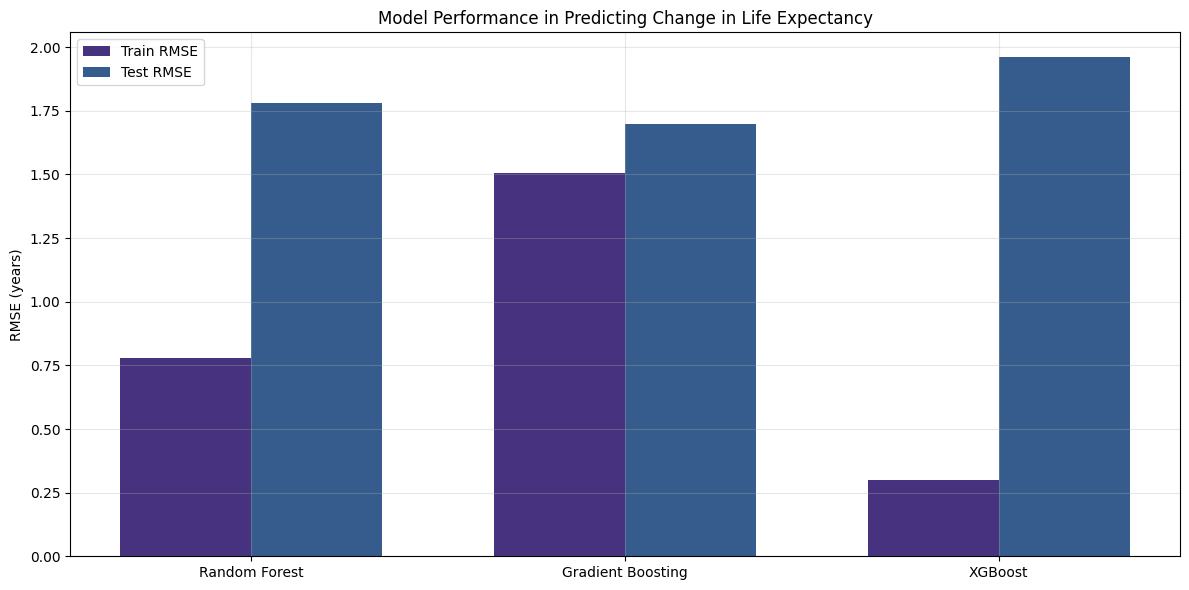

In [38]:
# Visualize model performance
plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, [results[m]['Train RMSE'] for m in results], width, label='Train RMSE')
ax.bar(x + width/2, [results[m]['Test RMSE'] for m in results], width, label='Test RMSE')

ax.set_ylabel('RMSE (years)')
ax.set_title('Model Performance in Predicting Change in Life Expectancy')
ax.set_xticks(x)
ax.set_xticklabels(results.keys())
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:

# Get the best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\nBest model for predicting change in life expectancy: {best_model_name}")


Best model for predicting change in life expectancy: Gradient Boosting


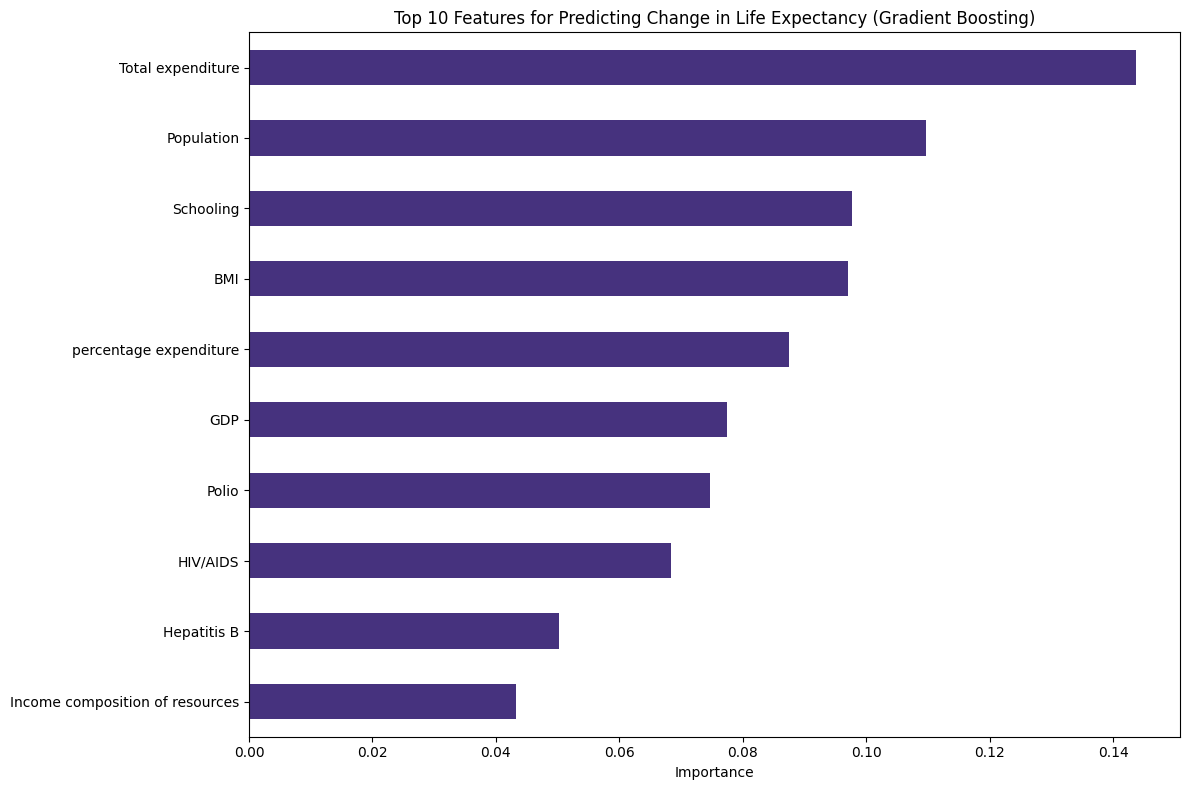


Top 10 features for predicting change in life expectancy:
Total expenditure                  0.143622
Population                         0.109634
Schooling                          0.097642
BMI                                0.096959
percentage expenditure             0.087444
GDP                                0.077478
Polio                              0.074720
HIV/AIDS                           0.068293
Hepatitis B                        0.050241
Income composition of resources    0.043322
dtype: float64


In [ ]:
# What are the top 10 features?
if best_model_name in feature_importances:
    plt.figure(figsize=(12, 8))
    top_10 = feature_importances[best_model_name].sort_values(ascending=False).head(10)
    top_10.sort_values(ascending=True).plot(kind='barh')  # Plot in ascending order for top-to-bottom
    plt.title(f'Top 10 Features for Predicting Change in Life Expectancy ({best_model_name})')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 features for predicting change in life expectancy:")
    print(top_10)

In [41]:
# Convert delta predictions back to absolute life expectancy
best_model_delta_train_pred = best_model.predict(X_train_scaled)
best_model_delta_test_pred = best_model.predict(X_test_scaled)

# Add the lagged variable back to get absolute predictions
best_model_train_pred = best_model_delta_train_pred + X_train[lagged_var].values
best_model_test_pred = best_model_delta_test_pred + X_test[lagged_var].values

# Calculate metrics for absolute predictions
abs_train_rmse = np.sqrt(mean_squared_error(y_train['Life expectancy'], best_model_train_pred))
abs_test_rmse = np.sqrt(mean_squared_error(y_test['Life expectancy'], best_model_test_pred))
abs_train_r2 = r2_score(y_train['Life expectancy'], best_model_train_pred)
abs_test_r2 = r2_score(y_test['Life expectancy'], best_model_test_pred)

print(f"\nPerformance of {best_model_name} when converting delta predictions back to absolute values:")
print(f"  Absolute Train RMSE: {abs_train_rmse:.4f}")
print(f"  Absolute Test RMSE: {abs_test_rmse:.4f}")
print(f"  Absolute Train R²: {abs_train_r2:.4f}")
print(f"  Absolute Test R²: {abs_test_r2:.4f}")


Performance of Gradient Boosting when converting delta predictions back to absolute values:
  Absolute Train RMSE: 1.5074
  Absolute Test RMSE: 1.6964
  Absolute Train R²: 0.9742
  Absolute Test R²: 0.9694


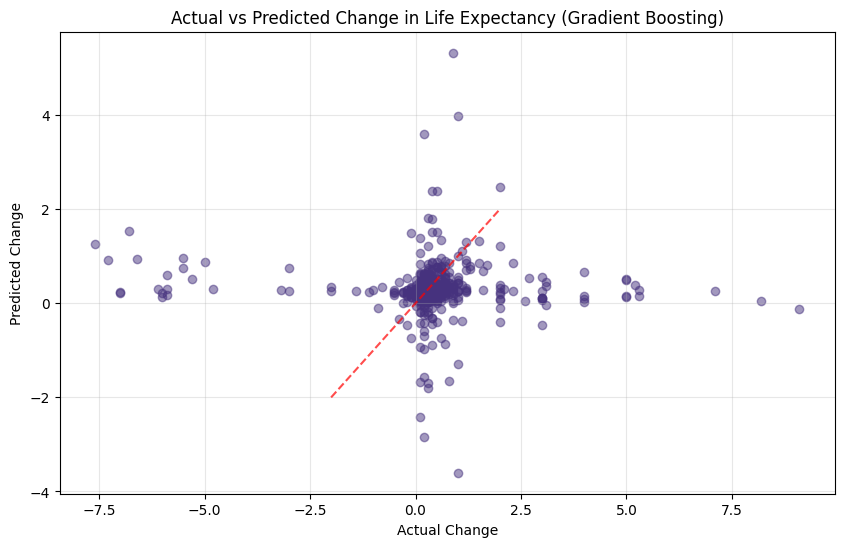

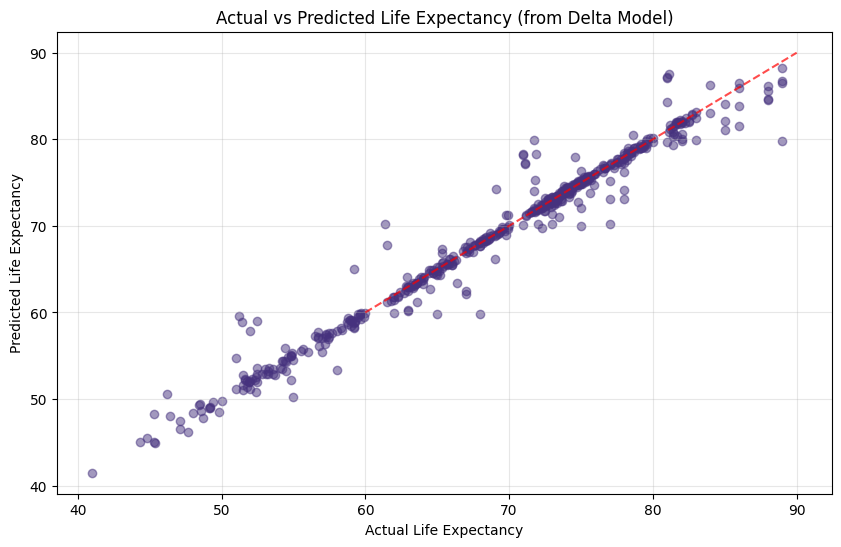

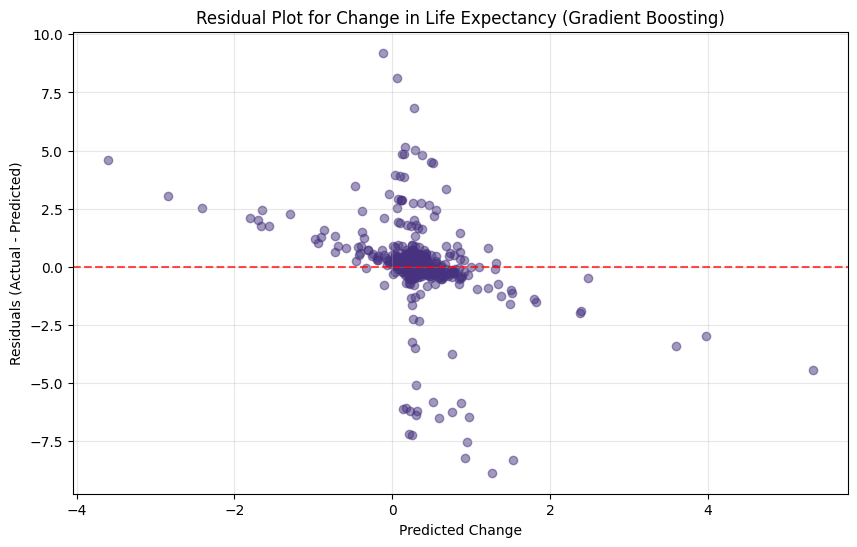

In [42]:

# Compare actual vs predicted changes
plt.figure(figsize=(10, 6))
plt.scatter(y_test_delta, best_model_delta_test_pred, alpha=0.5)
plt.plot([-2, 2], [-2, 2], 'r--', alpha=0.7)  # Perfect prediction line
plt.title(f'Actual vs Predicted Change in Life Expectancy ({best_model_name})')
plt.xlabel('Actual Change')
plt.ylabel('Predicted Change')
plt.grid(True, alpha=0.3)
plt.show()

# Compare actual vs predicted absolute values
plt.figure(figsize=(10, 6))
plt.scatter(y_test['Life expectancy'], best_model_test_pred, alpha=0.5)
plt.plot([60, 90], [60, 90], 'r--', alpha=0.7)  # Perfect prediction line
plt.title(f'Actual vs Predicted Life Expectancy (from Delta Model)')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.grid(True, alpha=0.3)
plt.show()

# Create a residual plot for delta predictions
plt.figure(figsize=(10, 6))
residuals = y_test_delta - best_model_delta_test_pred
plt.scatter(best_model_delta_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title(f'Residual Plot for Change in Life Expectancy ({best_model_name})')
plt.xlabel('Predicted Change')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, alpha=0.3)
plt.show()
